In [10]:
# Multi-turn Zero-shot ABSA on 
# my_env

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
import squarify
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from transformers import pipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# pipeline for Zero-Shot Classification w NLI (NLI), better to identify keywords for candidate_labels
# nli1: facebook/bart-large-mnli -> # https://huggingface.co/facebook/bart-large-mnli?library=transformers
# nli2: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli -> # https://huggingface.co/MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli?library=transformers
# nli3: cross-encoder/nli-roberta-base -> # https://huggingface.co/cross-encoder/nli-roberta-base?library=transformers

nli1 = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)
nli2 = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", device=device)
nli3 = pipeline("zero-shot-classification", model="cross-encoder/nli-roberta-base", device=device)


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
df = pd.read_csv('combined_dfv4.csv')

# Define the aspect columns to check
aspect_columns = ['aspect_Cost', 'aspect_Instant Ink', 'aspect_Quality', 'aspect_Services', 'aspect_Shipment']

# Filter the DataFrame
reviews = df[
    (df['Survey language'] == 'English') &
    (df['Month of Response Date'] == "Apr-24") &
    (df[aspect_columns].sum(axis=1) != 0)  # Check if the sum of the aspect columns is not zero
][['Survey ID', 'Combined Text']]

len(reviews)

4306

In [10]:
from datasets import Dataset
import pandas as pd

# Select the NLI model to use
nli = nli1

# Define categories
cats = ['Cost', 'Instant Ink', 'Quality', 'Services', 'Shipment']

# Prepare the dataset for efficient batch processing
reviews_dataset = Dataset.from_pandas(reviews[['Survey ID', 'Combined Text']])  # Create a Hugging Face Dataset with 'Survey ID' and 'Combined Text'

# Define a function to process each review and classify categories and sentiment
def process_review(batch):
    batch_results = []  # Store results for each batch
    
    for survey_id, s in zip(batch['Survey ID'], batch['Combined Text']):
        labels = []

        # Find applicable categories
        for c in cats:
            yes = f"It's a comment on {c}"
            no = f"It's not a comment on {c}"
            res = nli(s, candidate_labels=[yes, no])
            label = res['labels'][0]
            if res['scores'][0] >= 0.9 and "not" not in label:
                labels.append(c)

        # If no specific category is detected, assign "General"
        if not labels:
            labels.append('General')

        # Determine the polarity for each detected category (only positive or negative)
        review_results = []  # Temporary store for each sentence's result
        for l in labels:
            # Directly use 'positive' and 'negative' without creating additional strings
            res2 = nli(s, candidate_labels=['positive', 'neutral', 'negative'])
            polarity = res2['labels'][0]  # Directly get 'positive' or 'negative'
            
            review_results.append({
                "Survey ID": survey_id,  # Include Survey ID in the results
                "sentence": s,
                "cat": l,
                "polarity": polarity,  # Store polarity directly as 'positive' or 'negative'
                "polarity_score": res2['scores'][0]
            })
        
        # Append review_results for this sentence to batch_results
        batch_results.append(review_results)
    
    return {"results": batch_results}

# Apply the function to the dataset and process in batches
processed_results = reviews_dataset.map(lambda batch: process_review(batch), batched=True)

# Flatten the results list to avoid ArrowInvalid error (if each review has multiple labels)
flat_results = [item for sublist in processed_results["results"] for item in sublist]

# Convert the processed flattened results into a pandas DataFrame
df_results = pd.DataFrame(flat_results)
output_path = 'Multi-Turn Zero-Shot ABSA/nli1_df_results.csv'  # Replace 'your/path/here' with the actual file path
df_results.to_csv(output_path, index=False)

df_results.head(10)


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

,Survey ID,cat,polarity,polarity_score,sentence
0,110020182,Instant Ink,positive,0.994894,"Excllent quality; easy to order, received prom..."
1,110020182,Quality,positive,0.994894,"Excllent quality; easy to order, received prom..."
2,110020182,Shipment,positive,0.994894,"Excllent quality; easy to order, received prom..."
3,123460320,General,positive,0.985882,Great price and arrived even earlier than stated.
4,133472112,Cost,positive,0.930847,"Price competitive with other sources, but deli..."
5,133472112,Quality,positive,0.930847,"Price competitive with other sources, but deli..."
6,133472112,Shipment,positive,0.930847,"Price competitive with other sources, but deli..."
7,134550233,General,negative,0.901488,Don't know. Never received my order
8,134626563,Quality,positive,0.928483,[This review was collected as part of a promot...
9,172491173,Instant Ink,positive,0.957588,I am so pleased with the supply of ink in this...


In [26]:
# Define the list of NLI models to use
nli_models = [nli1, nli2, nli3]
model_names = ['nli1', 'nli2', 'nli3']

# Define categories
cats = ['Cost', 'Instant Ink', 'Others', 'Quality', 'Shipment']

# Prepare the dataset for efficient batch processing
reviews_dataset = Dataset.from_pandas(reviews[['Survey ID', 'Combined Text']])  # Create a Hugging Face Dataset with 'Survey ID' and 'Combined Text'

# Define a function to process each review and classify categories and sentiment
def process_review(batch, nli):
    batch_results = []  # Store results for each batch
    
    for survey_id, s in zip(batch['Survey ID'], batch['Combined Text']):
        labels = []

        # Find applicable categories
        for c in cats:
            yes = f"It's a comment on {c}"
            no = f"It's not a comment on {c}"
            res = nli(s, candidate_labels=[yes, no])
            label = res['labels'][0]
            if res['scores'][0] >= 0.9 and "not" not in label:
                labels.append(c)

        # If no specific category is detected, assign "General"
        if not labels:
            labels.append('General')

        # Determine the polarity for each detected category (only positive or negative)
        review_results = []  # Temporary store for each sentence's result
        for l in labels:
            # Directly use 'positive' and 'negative' without creating additional strings
            res2 = nli(s, candidate_labels=['positive', 'neutral', 'negative'])
            polarity = res2['labels'][0]  # Directly get 'positive' or 'negative'
            
            review_results.append({
                "Survey ID": survey_id,  # Include Survey ID in the results
                "sentence": s,
                "cat": l,
                "polarity": polarity,  # Store polarity directly as 'positive' or 'negative'
                "polarity_score": res2['scores'][0]
            })
        
        # Append review_results for this sentence to batch_results
        batch_results.append(review_results)
    
    return {"results": batch_results}

# Iterate through each NLI model and process the dataset
for nli, model_name in zip(nli_models, model_names):
    # Apply the function to the dataset and process in batches
    processed_results = reviews_dataset.map(lambda batch: process_review(batch, nli), batched=True)

    # Flatten the results list to avoid ArrowInvalid error (if each review has multiple labels)
    flat_results = [item for sublist in processed_results["results"] for item in sublist]

    # Convert the processed flattened results into a pandas DataFrame
    df_results = pd.DataFrame(flat_results)
    
    # Export to CSV
    output_path = f'Multi-Turn Zero-Shot ABSA/{model_name}_df_results.csv'  # Create file path dynamically
    df_results.to_csv(output_path, index=False)


Map:   0%|          | 0/4306 [00:00<?, ? examples/s]

Map:   0%|          | 0/4306 [00:00<?, ? examples/s]

Map:   0%|          | 0/4306 [00:00<?, ? examples/s]

In [6]:
# File paths for the three CSV files
file_paths = [r"Multi-Turn Zero-Shot ABSA\nli1_df_results.csv", 
              r"Multi-Turn Zero-Shot ABSA\nli2_df_results.csv", 
              r"Multi-Turn Zero-Shot ABSA\nli3_df_results.csv"
              ]

# Loop through each file, process it individually, and display the result
for i, file in enumerate(file_paths, start=1):
    # Read each CSV file
    df_results = pd.read_csv(file)
    
    # Generate a summary table with cross-tabulation
    summary = pd.crosstab(df_results['cat'], df_results['polarity'])
    
    # Convert the summary into a DataFrame and add the category column
    df_summary = pd.DataFrame(summary)
    df_summary["category"] = df_summary.index
    
    # Handle missing columns for any missing sentiment labels
    for col in ['positive', 'negative']:
        if col not in df_summary.columns:
            df_summary[col] = 0
    
    # Calculate the total number of sentiments (positive + negative) per category
    df_summary["total"] = df_summary["positive"] + df_summary["negative"]
    
    # Calculate the overall sentiment score for each category
    # Score: (positive - negative) / (positive + negative)
    df_summary["sentiment"] = np.round((df_summary["positive"] - df_summary["negative"]) / (df_summary["positive"] + df_summary["negative"]), 2)
    
    # Display the summary DataFrame for each file
    print(f"Summary for file {i} ({file}):")
    print(df_summary)
    print("\n" + "="*50 + "\n")


Summary for file 1 (Multi-Turn Zero-Shot ABSA\nli1_df_results.csv):
polarity     negative  neutral  positive     category  total  sentiment
cat                                                                    
Cost             1185       11       393         Cost   1578      -0.50
General           716       35       343      General   1059      -0.35
Instant Ink       486        4       459  Instant Ink    945      -0.03
Others            873        1        50       Others    923      -0.89
Quality          1326       15       929      Quality   2255      -0.18
Shipment          222        2        73     Shipment    295      -0.51


Summary for file 2 (Multi-Turn Zero-Shot ABSA\nli2_df_results.csv):
polarity     negative  neutral  positive     category  total  sentiment
cat                                                                    
Cost              816       64       459         Cost   1275      -0.28
General          1019      144       447      General   1466      -0.3

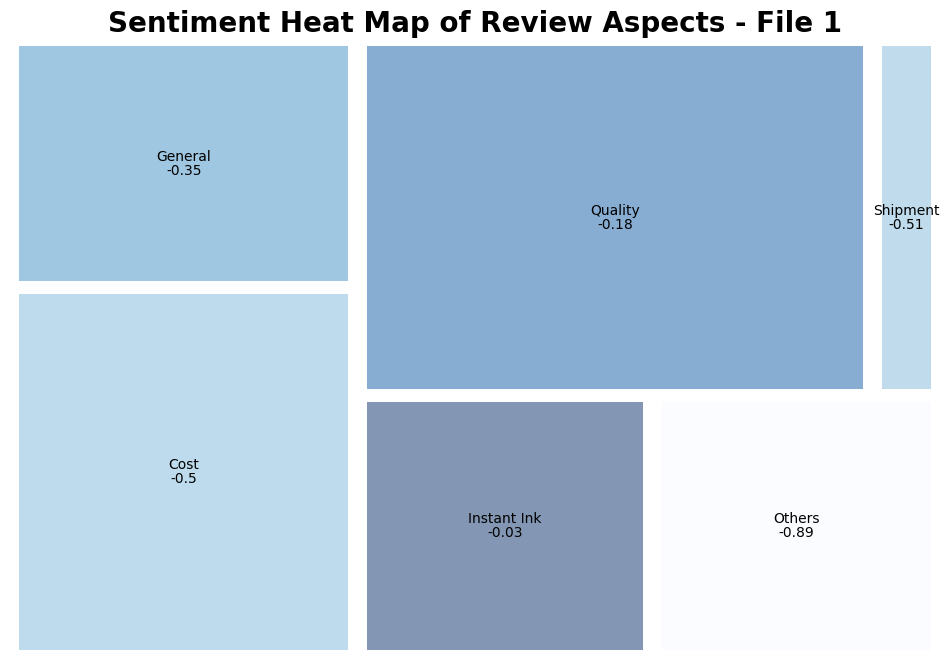

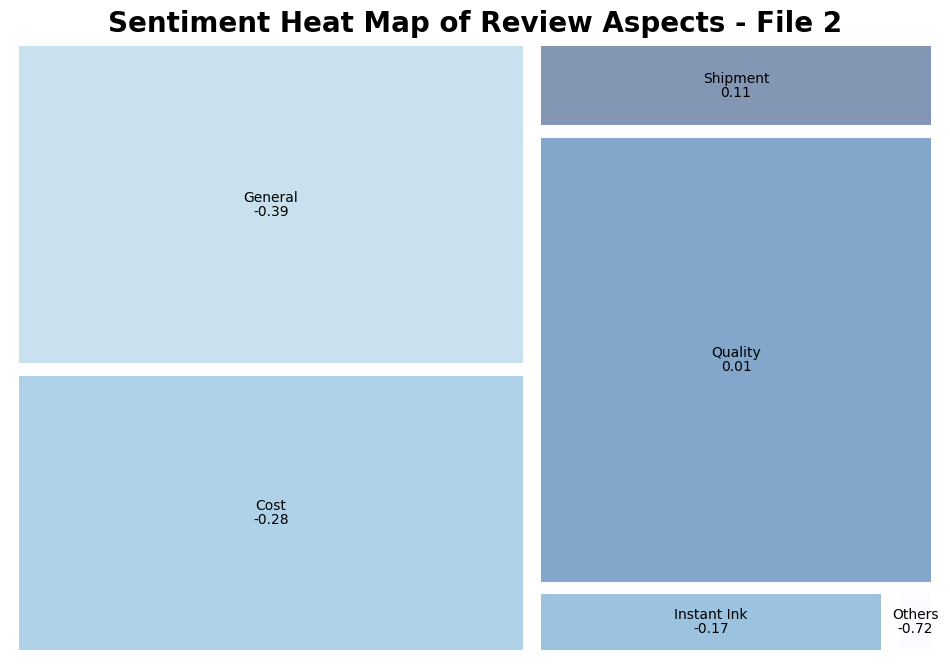

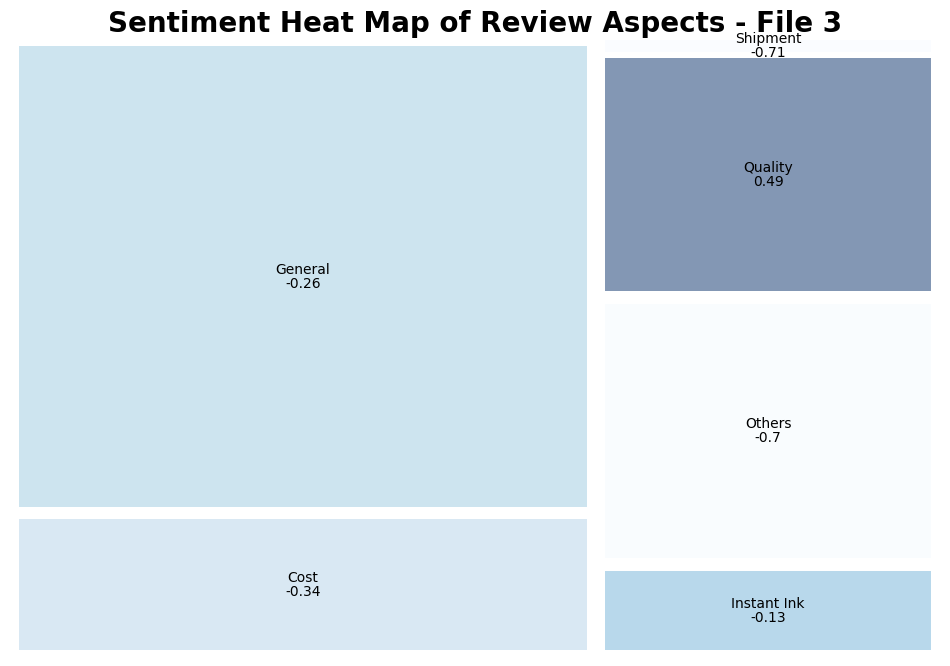

In [13]:
# Loop through each file, process it individually, and plot the treemap
for i, file in enumerate(file_paths, start=1):
    # Read each CSV file
    df_results = pd.read_csv(file)
    
    # Generate a summary table with cross-tabulation
    summary = pd.crosstab(df_results['cat'], df_results['polarity'])
    
    # Convert the summary into a DataFrame and add the category column
    df_summary = pd.DataFrame(summary)
    df_summary["category"] = df_summary.index
    
    # Handle missing columns for any missing sentiment labels
    for col in ['positive', 'negative']:
        if col not in df_summary.columns:
            df_summary[col] = 0
    
    # Calculate the total number of sentiments (positive + negative) per category
    df_summary["total"] = df_summary["positive"] + df_summary["negative"]
    
    # Calculate the overall sentiment score for each category
    df_summary["sentiment"] = np.round((df_summary["positive"] - df_summary["negative"]) / (df_summary["positive"] + df_summary["negative"]), 2)
    
    # Normalize sentiment values for color intensity
    norm = matplotlib.colors.Normalize(vmin=min(df_summary.sentiment), vmax=max(df_summary.sentiment))
    colors = [matplotlib.cm.Blues(norm(value)) for value in df_summary.sentiment]

    # Plot treemap for each summary
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    # Plot treemap using squarify with colors based on sentiment values
    squarify.plot(label=df_summary.category, sizes=df_summary.total, value=df_summary.sentiment, color=colors, alpha=.5, pad=True)
    
    plt.title(f"Sentiment Heat Map of Review Aspects - File {i}", fontsize=20, fontweight="bold")
    plt.axis('off')  # Turn off the axis for a cleaner plot
    plt.show()

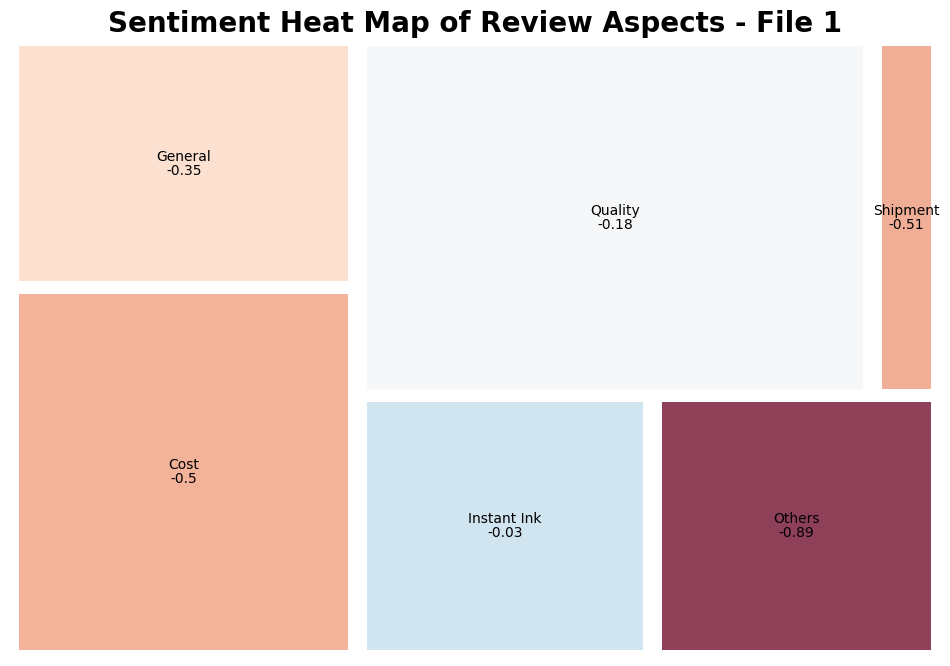

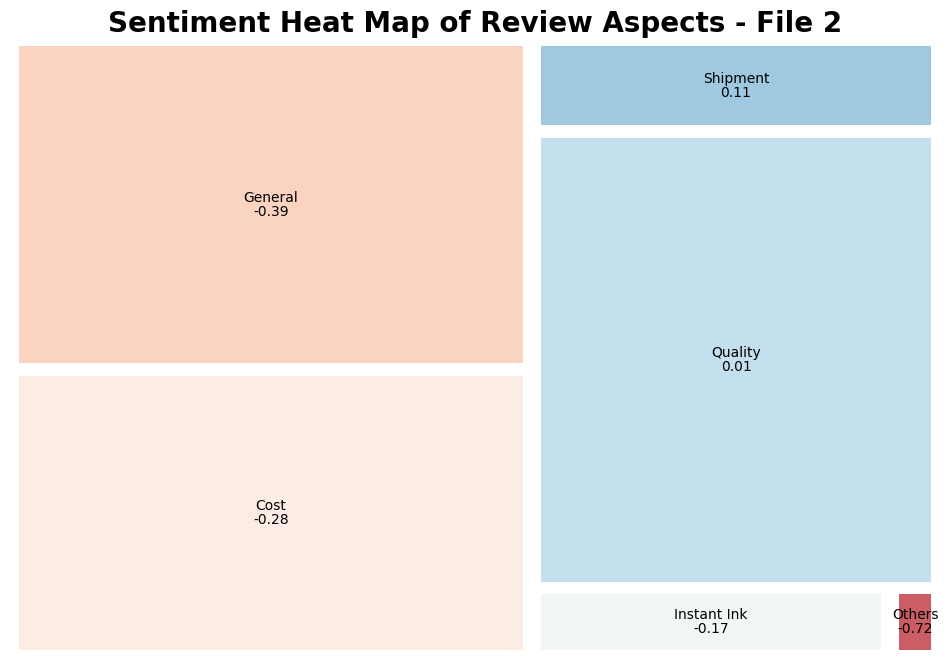

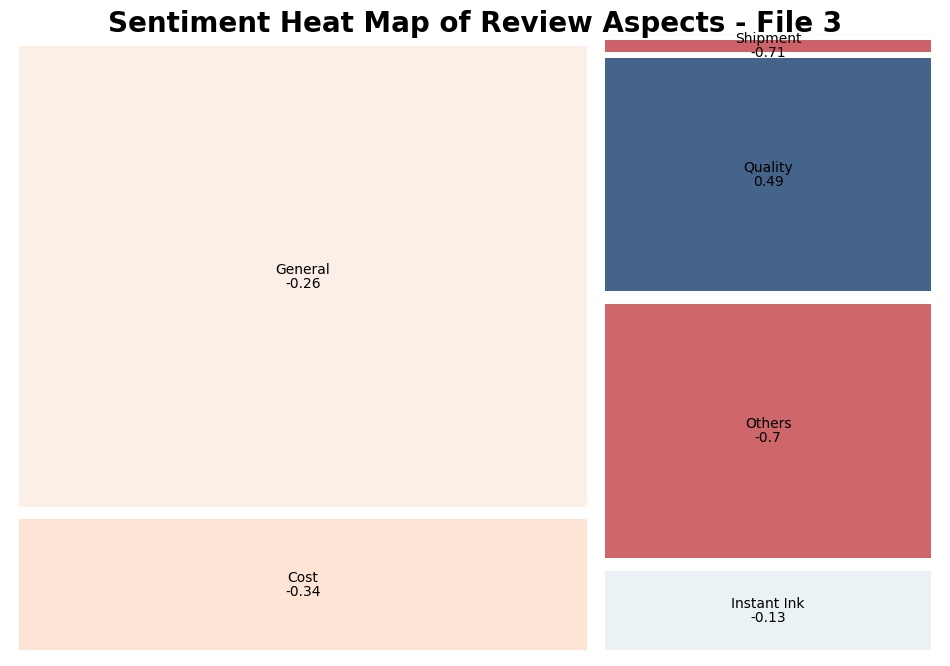

In [15]:
dfs = []

# Step 1: Read all files and calculate the global min/max for sentiment values
for file in file_paths:
    df_results = pd.read_csv(file)
    # Generate a summary table with cross-tabulation
    summary = pd.crosstab(df_results['cat'], df_results['polarity'])
    
    # Convert the summary into a DataFrame and add the category column
    df_summary = pd.DataFrame(summary)
    df_summary["category"] = df_summary.index
    
    # Handle missing columns for any missing sentiment labels
    for col in ['positive', 'negative']:
        if col not in df_summary.columns:
            df_summary[col] = 0
    
    # Calculate the total number of sentiments (positive + negative) per category
    df_summary["total"] = df_summary["positive"] + df_summary["negative"]
    
    # Calculate the overall sentiment score for each category
    df_summary["sentiment"] = np.round((df_summary["positive"] - df_summary["negative"]) / (df_summary["positive"] + df_summary["negative"]), 2)
    
    # Store the DataFrame for later use
    dfs.append(df_summary)

# Step 2: Find the global min and max sentiment values across all DataFrames
all_sentiments = pd.concat([df['sentiment'] for df in dfs])
global_min = all_sentiments.min()
global_max = all_sentiments.max()

# Step 3: Normalize using global min and max values and plot each treemap
norm = matplotlib.colors.Normalize(vmin=global_min, vmax=global_max)

for i, df_summary in enumerate(dfs, start=1):
    # Normalize sentiment values for consistent color intensity across plots
    colors = [matplotlib.cm.RdBu(norm(value)) for value in df_summary.sentiment]

    # Plot treemap for each summary
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    # Plot treemap using squarify with global color normalization
    squarify.plot(label=df_summary.category, sizes=df_summary.total, value=df_summary.sentiment, color=colors, alpha=.75, pad=True)
    
    plt.title(f"Sentiment Heat Map of Review Aspects - File {i}", fontsize=20, fontweight="bold")
    plt.axis('off')  # Turn off the axis for a cleaner plot
    plt.show()
